In [32]:
%matplotlib inline
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

In [33]:
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.video.io.VideoFileClip import VideoFileClip
from scipy import misc

# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5.  Detect lane pixels and fit to find the lane boundary.
6.  Determine the curvature of the lane and vehicle position with respect to center.
7.  Warp the detected lane boundaries back onto the original image.
8.  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Rubric Points

1) The first thing to do was to calibrate the camera using the test calibration images provided by Udacity. These images were chessgrids, of size 9x6, take and different angles on a wall. Since a camera lense is slightly distorted due to the concave/convex lense curvature, any image that is pulled will be slightly distorted. 

Hence we need to undistort the image. I wrote a function that will undisort the image, but before that, i had to compute the calibration using Udacity's object/image point extraction code provided. This means I will only need to calibrate the camera once and save these weights for use in the pipeline later on.


# Extract object points and image points - FULL CREDIT TO UDACITY's/Ryan Keenan's Github

In [35]:
# Here we use 9x6 instead of 8x6 chessboard
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
#images = glob.glob('D:/Self Driving Car Engineer/P4/calibration_wide/GO*.jpg')


PATH= "D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/camera_cal/"
images =os.listdir(PATH)

for i in range(len(images)):  
    img = (cv2.imread(PATH+images[i])) #original image
    # Step through the list and search for chessboard corners
    #for idx, fname in enumerate(images):
    #img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    
    #save  the points for further use
    np.save('D:/Self Driving Car Engineer/P4/data/objpoints', objpoints)
    np.save('D:/Self Driving Car Engineer/P4/data/imgpoints', imgpoints)

cv2.destroyAllWindows()

Here I create the undistort function using CV2 commands.

In [36]:
def undistort(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    calibration = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None) #gives calibration matrix
    return cv2.undistort(img, calibration[1] , calibration[2], None, calibration[1]) #takes calibration matrix, undistort image

In [43]:
w = mpimg.imread("D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/camera_cal/calibration3.jpg")
#plt.imshow(w)

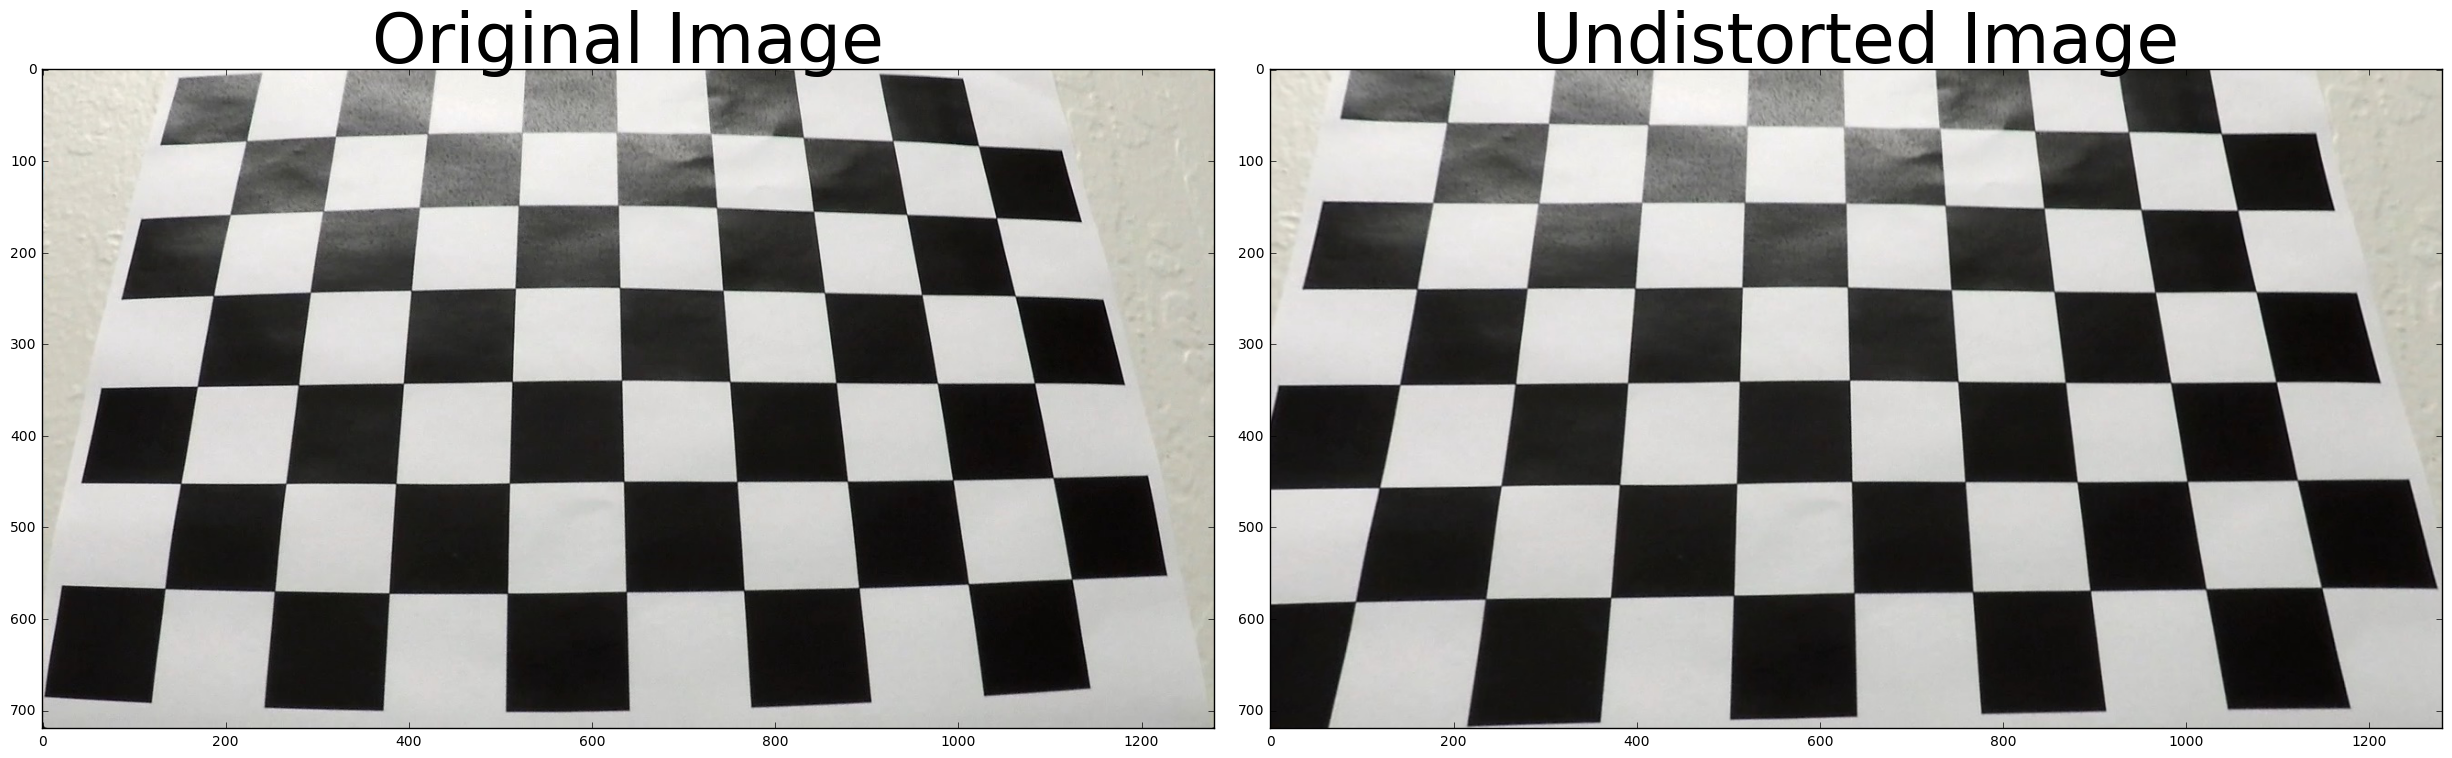

In [44]:
e = undistort(w)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(w)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(e)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Here  you can clearly see that the image is undistorted and looks much more flat and corrected

In [49]:
image = mpimg.imread('D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/test_images/test6.jpg')
#plt.imshow(image) #the image is 1280 by 720

In [48]:
a = undistort(image)
#plt.imshow(a) #image is undistorted slightly at the edges

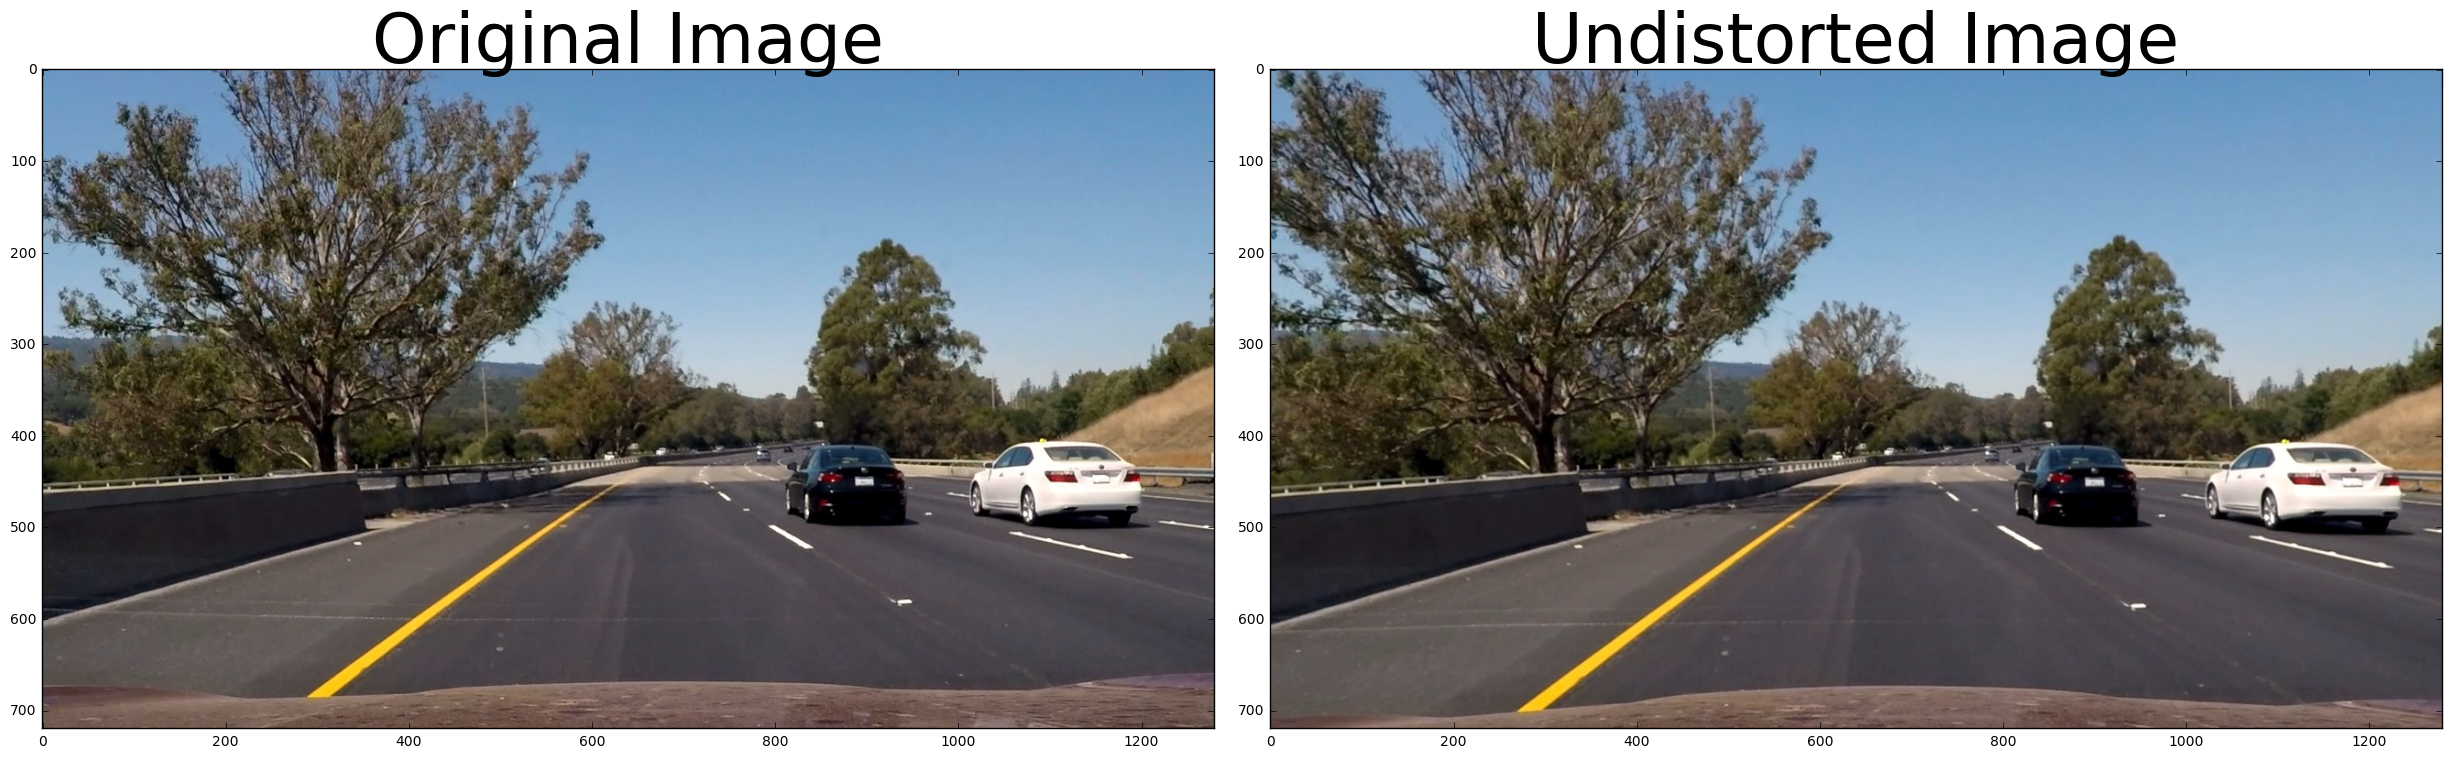

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(a)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

And when applied to an example image, you can clearly see that the image is undistorted and looks corrected especially at the sides and corners of the trees and white car.

# Colour and Gradient threshold

2) Next I had to compute colour transforms and gradients in order to spot the lane lines. This is actucally very similar to the canny effect method in Project 1, but instead of computing the gradient using only RGB values, we dived into the colour detection method, and can further tweak our colour and gradient thresholds. Since our previous project could not spot light/dark areas, by using HSV (hue saturation, value) we can distinguish light and dark areas. Also we further dived into the Sobel gradient, in order to find our edges for the lane lines. Since most lane lines are roughly sraight up, we can discard most of the unwanted edges lines such as cars or traffic signs.I wrote a function that will perform these two operations.

Now, if I had more time without work and real-life commitments, I would definitely spend more time in this section and experiment with many more different colour thresholds. HSL seems to be very useful as well but i did not have the time unfortunately.

In [8]:
def threshold(img, s_thresh=(180, 253), sx_thresh=(15, 190)):

    #
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]


    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary
    


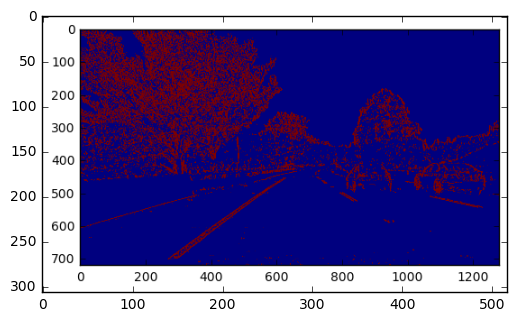

In [47]:
thresh = mpimg.imread('D:/Self Driving Car Engineer/P4/output_images/HSV_threshold.png')
plt.imshow(thresh)

In the above image, here we compute the HSV colour and gradient tranformations.


# Perspective Transform

3) Next we use a perspective transform, to stretch the image from the road, into a flat 2D image, as if we are looking at the road from above. This is useful, beacuse now we can computed the curvature of these lines, and this will make the lanes roughly parallel. Again, I wrote a function that will use perspective transform to skew the image.

Similar to my 1st project in lanefinding, we cut out a trapezium shape that will include our lane lines, and strethc this into a rectangle shape. I define a function for this. I also create a function to unwarp our image at the end.

In [15]:
trapezium = np.float32([[580, 460],[700, 460],[1040, 680],[260, 680], ])
rectangle = np.float32([[260, 0],[1040, 0],[1040, 720],[260, 720],])
transform = cv2.getPerspectiveTransform(trapezium, rectangle)
INVtransform = cv2.getPerspectiveTransform(rectangle, trapezium)

def warp(img):
    # 
    trapezium = np.float32([[580, 460],[700, 460],[1040, 680],[260, 680], ])
    rectangle = np.float32([[260, 0],[1040, 0],[1040, 720],[260, 720],])
    transform = cv2.getPerspectiveTransform(trapezium, rectangle)
    INVtransform = cv2.getPerspectiveTransform(rectangle, trapezium)
    
    return cv2.warpPerspective(img, transform, (img.shape[1], img.shape[0]),flags=cv2.INTER_LINEAR)

In [16]:
def unwarp(img):
        return cv2.warpPersective(img, INVtransform,(img.shape[1], img.shape[0]),flags=cv2.INTER_LINEAR)

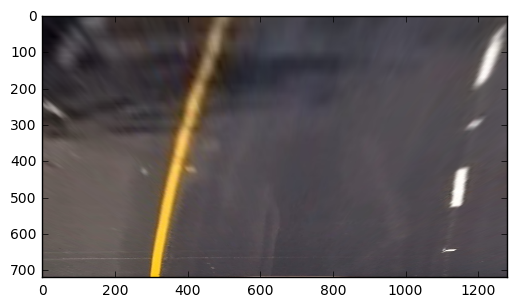

In [17]:
z = warp(a)
plt.imshow(z)

Here is an example of using the perspective transform in the same image at the top.

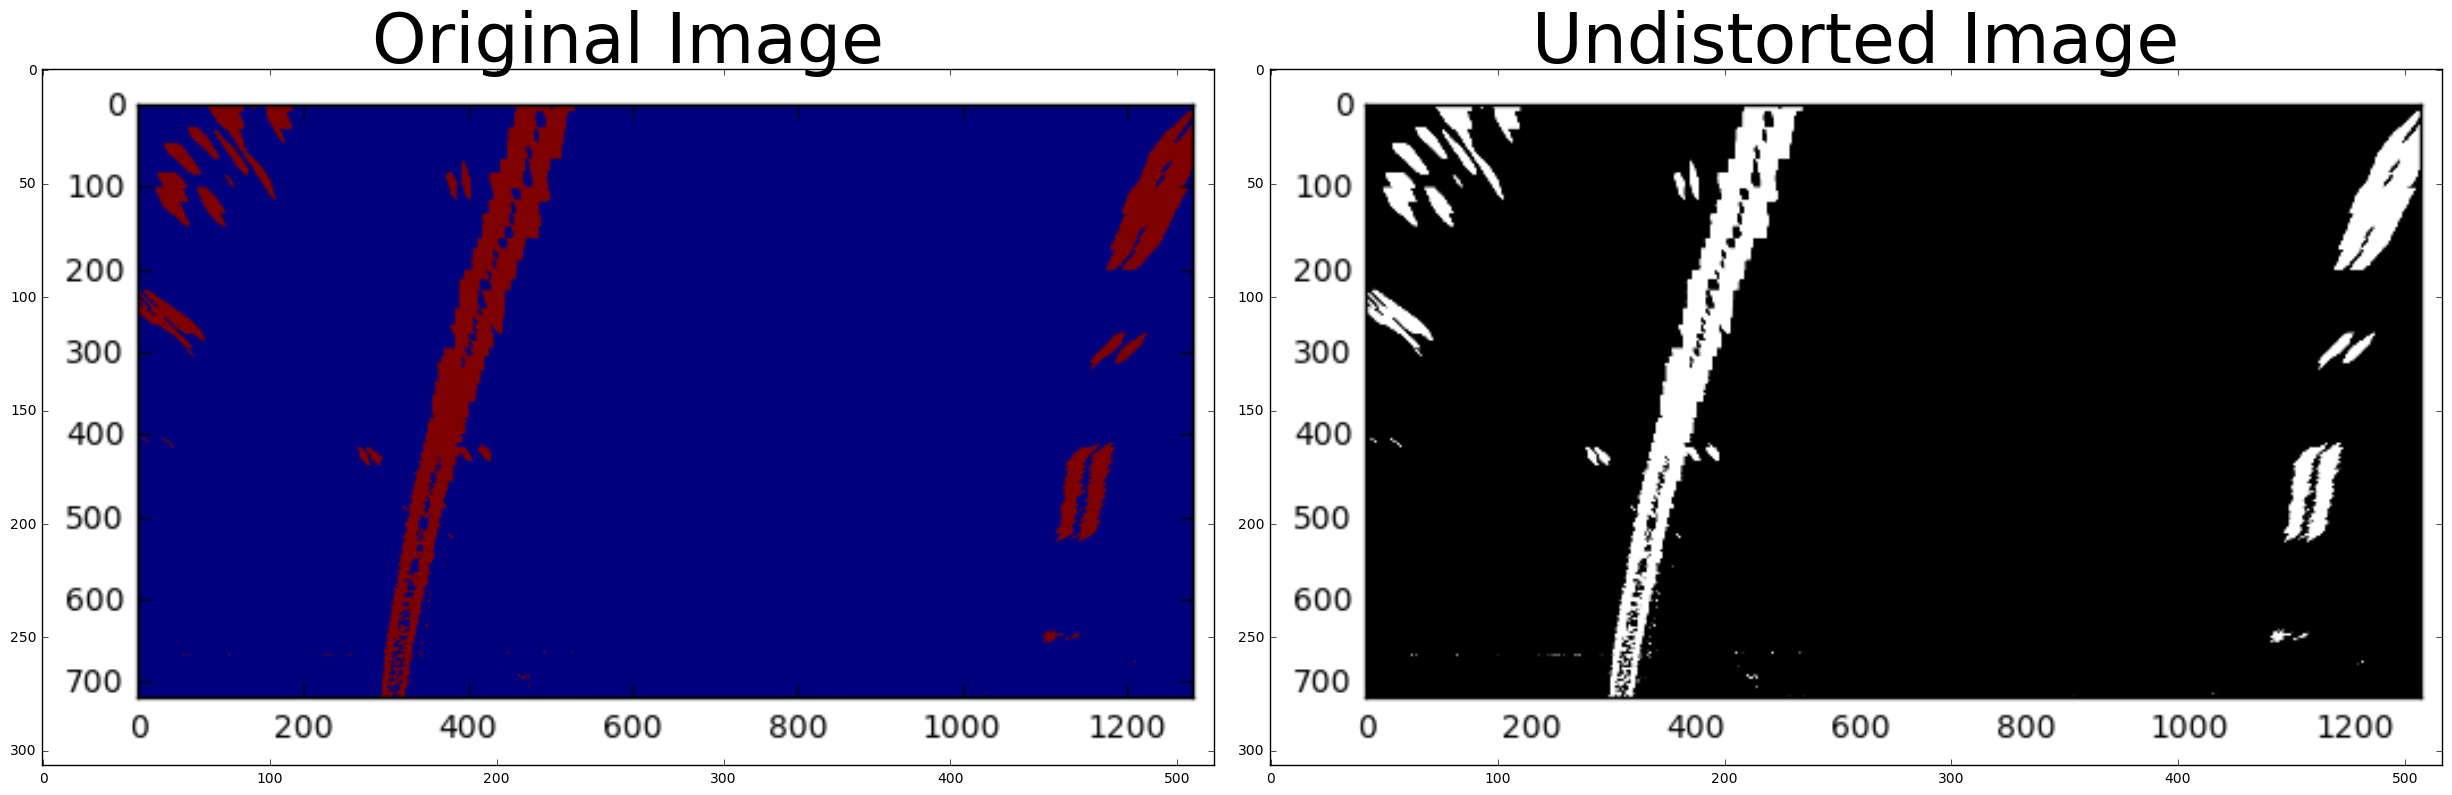

In [51]:
HSV_trans = mpimg.imread('D:/Self Driving Car Engineer/P4/output_images/HSV_transform.png')
#plt.imshow(HSV_trans)
HSV_gray = mpimg.imread('D:/Self Driving Car Engineer/P4/output_images/HSV_grayscale.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(HSV_trans)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(HSV_gray)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In the above images, i use my perspective transform, and compute the color and gradient thresholds. I also apply a greyscale to fully make the lane lines standout. We use Udacity's gradient histogram, and cut our image in half, to find two biggest 'peaks' at the bottom by adding up all the pixels. 

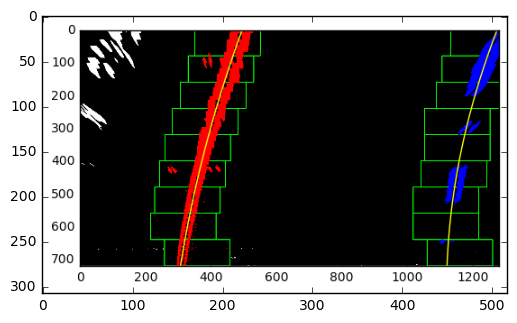

In [54]:
curve_ = mpimg.imread('D:/Self Driving Car Engineer/P4/output_images/grad.png')
plt.imshow(curve_)

Here we use the sliding window method provided by Udacity to compute the curvature for the gradient.

# Pipeline - Curvature and Video Output

4) The final step is to compute the gradients of the functions. This is simply taking the derivative, of our curves, and the code was generously provided by Udacity. After this step we simply work backwards, and transform our image back into the original trapezium shape, and fill in the shaded area. Now we can see the area that the car can travel on!

We combine our 3 written functions together, and compute the curvature. We can join the dots and this will give us our region or polygon to fill in using a simple openCV command. I also include some text that will display the curvature of these lane lines, and our distance towards the centre of the road. Again, many thanks to Udacity for providing these codes.

In [21]:
def pipeline(original):

    undistorted = undistort(original)
    misc.imsave('D:/Self Driving Car Engineer/P4/output_images/undistorted.jpg', undistorted)
     
    img = threshold(undistorted)
    misc.imsave('D:/Self Driving Car Engineer/P4/output_images/thresholded.jpg', img)
    #plt.imshow(img)
    
    binary_warped = warp(img)
    misc.imsave('D:/Self Driving Car Engineer/P4/output_images/warped.jpg', binary_warped)
    #plt.imshow(binary_warped)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #  Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    #drawing the lines  back onto the road
    # Create an image to draw the lines on
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #print('shape of warp zero') #DEBUGGING
    #print(warp_zero.shape) #DEBUGGING
    
    #Here we need to stack our image 3 times, so our shape is the same as our image (1280,720,3)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #print('shape of colour warp') #DEBUGGING
    #print(color_warp.shape) #DEBUGGING
    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print('these are points')  #DEBUGGING
    #print(pts) #DEBUGGING
    pts = np.array(pts, dtype=np.int32)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0,255, 0)) 

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, INVtransform, (binary_warped.shape[1], binary_warped.shape[0])) 
    
    #print('shape of newwarp') #DEBUGGING
    #print(newwarp.shape) #DEBUGGING
    
    #print('shape of undistorted') #DEBUGGING
    #print(undistorted.shape) #DEBUGGING
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    #plt.imshow(result) #DEBUGGING
    
    #here is the gradient of line curvature
    ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
    quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
    leftx = np.array([200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                          for y in ploty])
    rightx = np.array([900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                           for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    y_eval = np.max(ploty)

    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    #Calculate the new radii of curvature
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
    right_curverad = ((1 + ( 2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[
                                     1]) ** 2) ** 1.5) / np.absolute(  2 * right_fit_cr[0])
    
    # checking that our radii curvature for the lanes are roughly the same
    ratio = left_curverad / right_curverad
    if ratio < 0.66 or ratio > 1.5:
         print('Warning: bad ratio {}'.format(ratio))

    lane_leftx = left_fit[0] * (img.shape[0] - 1) ** 2 + left_fit[1] * (img.shape[0] - 1) + left_fit[2]
    lane_rightx = right_fit[0] * (img.shape[0] - 1) ** 2 + right_fit[1] * (img.shape[0] - 1) + right_fit[2]
    
    #we convert from pixel space to metres
    car_pos = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix
    
    lane_curve = (left_curverad + right_curverad) / 2
    car_pos = car_pos.round(2)
    
    
    if car_pos > 0:
        car_pos_text = '{}m right of center'.format(car_pos)
    else:
        car_pos_text = '{}m left of center'.format(abs(car_pos))
    
    # put the text on the final image
    cv2.putText(result, "Lane curve: {}m".format(lane_curve.round()), (10, 50), cv2.FONT_HERSHEY_PLAIN, 1,
                color=(255, 255, 255), thickness=2)
    cv2.putText(result, "Car is {}".format(car_pos_text), (10, 100), cv2.FONT_HERSHEY_PLAIN, 1, color=(255, 255, 255),
                thickness=2)
    
    #plt.imshow(result) #DEBUGGING
    
    return result

# Pipeline 

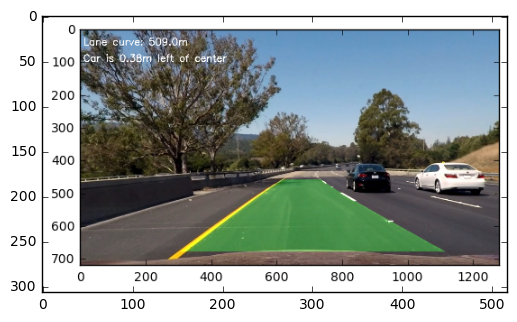

In [52]:
final_= mpimg.imread('D:/Self Driving Car Engineer/P4/output_images/final.png')
plt.imshow(final_)

Here we have our output!! Now onward to the videos! Please see the attached videos in the zip file.

[MoviePy] >>>> Building video {}_done_2.mp4
[MoviePy] Writing video {}_done_2.mp4


 79%|███████████████████████████████▋        | 416/526 [06:08<01:36,  1.14it/s]

100%|███████████████████████████████████████▉| 525/526 [07:43<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: {}_done_2.mp4 

Wall time: 7min 44s


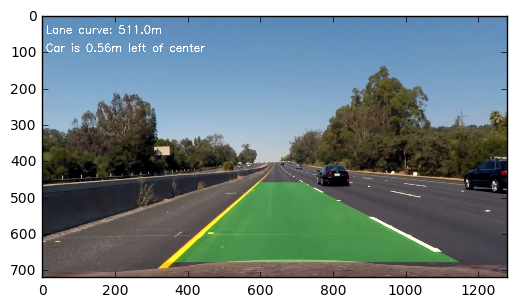

In [19]:
video = "D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/project_video"
white_output = '{}_done_2.mp4'
clip1 = VideoFileClip('{}.mp4'.format(video)).subclip(30, 51)
#clip1 = VideoFileClip(video)

white_clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

In [23]:
video = "D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/project_video.mp4"
white_output = '{}_done_full.mp4'
#clip1 = VideoFileClip('{}.mp4'.format(video)).subclip(30, 51)
clip1 = VideoFileClip(video)

white_clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video {}_done_full.mp4
[MoviePy] Writing video {}_done_full.mp4


 48%|██████████████████▋                    | 606/1261 [08:44<09:17,  1.18it/s]

100%|█████████████████████████████████████▉| 1260/1261 [18:05<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: {}_done_full.mp4 

Wall time: 18min 6s


In [25]:
video = "D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/challenge_video"
white_output = '{}_challenge_2.mp4'
clip1 = VideoFileClip('{}.mp4'.format(video)).subclip(12, 16)
#clip1 = VideoFileClip(video)

white_clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video {}_done_2.mp4
[MoviePy] Writing video {}_done_2.mp4


100%|████████████████████████████████████████| 120/120 [01:45<00:00,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: {}_done_2.mp4 

Wall time: 1min 47s


In [26]:
video = "D:/Self Driving Car Engineer/P4/CarND-Advanced-Lane-Lines-master/challenge_video.mp4"
white_output = '{}_challenge_full.mp4'
#clip1 = VideoFileClip('{}.mp4'.format(video)).subclip(30, 51)
clip1 = VideoFileClip(video)

white_clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video {}_challenge_full.mp4
[MoviePy] Writing video {}_challenge_full.mp4


  2%|▉                                        | 11/485 [00:10<07:16,  1.08it/s]

 87%|██████████████████████████████████▋     | 421/485 [06:28<01:04,  1.01s/it]

100%|████████████████████████████████████████| 485/485 [07:29<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: {}_challenge_full.mp4 

Wall time: 7min 30s


# Final Thoughts and Possible Future Improvements

First of all, this was a much more easier (and therefore much less stressful) project and I really enjoyed it! I would definitely spend more time experimenting with the gradient and colour thresholds, as I know it is really too simple, and and more in depth combination will produce more satisfying and more accurate results. Due to real life commitments I couldnt really spend much time on this part.

Out of curiosity, I also inputed  the challenge video into my algorithm, and unsurprisingly, the lane areas were all over the place, due to the deep contrasts in the tar and road tarmac messing up the HSV lane detection. I would definitely want to check out the HSL colour pallette as well as playing around with the different values to see if this can be fixed. I havnt tried the harder-challenge video yet...

Having looked at the harder-challenge video, there are many steep, tight turns, which means further improvement to the curve and perspective transform may be needed. So for tight turns, perhaps a wider area may need to be transformed in order to see larger sections of the road. 

The other final limitation that I still think about, is what would happen at night or pitch black darkness when the headlights fail or no street lamps? Surely no amount of colour changing can change the fact that relying on just images, is a bit risky. I think we may still need affordable lidar and/or radar, or wait until the sensors are small enought to be installed in the car without affecting the car's aerodynamics. As a budding car designer who attend design school this year in Italy, I refuse to put huge, ugly lidar sensors in any car, and I'd rather wait until the sensors have been improved. So far, this still feels like a steering assist software, (or tesla's generation 1 autopilot) but I think its friggin amazing that students such as us, can create basic autopilot software in less the 3 months! 

[You can watch my project video here!](https://drive.google.com/open?id=0B7wHdgyuTB_lcVUzSTF4VFRoSVk)


[Here is my challenge project video](https://drive.google.com/open?id=0B7wHdgyuTB_lRGZuMjJOTVJvVnc)